In [39]:
import os
from os.path import join
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

In [45]:
sampled_img_dir = "logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img"
sampled_img_files = os.listdir(sampled_img_dir)
sampled_img_files = [join(sampled_img_dir, f) for f in sampled_img_files]
sampled_img_files[:10]

['logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_002136.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_000792.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_003996.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_002356.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_001994.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_001422.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_000178.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_001399.png',
 'logs/2024-04-24T18-31-43_afhq-ldm-kl-16-jepa-vae/samples/00022950/2024-04-28-17-11-48/img/sample_00113

In [5]:
train_images_dir = "data/afhq"
train_files = "data/afhq/train.txt"
train_files = open(train_files).read().splitlines()
train_files = [join(train_images_dir, f) for f in train_files]
train_files[:10]

['data/afhq/train/cat/pixabay_cat_003245.jpg',
 'data/afhq/train/cat/pixabay_cat_002131.jpg',
 'data/afhq/train/cat/pixabay_cat_002301.jpg',
 'data/afhq/train/cat/pixabay_cat_000306.jpg',
 'data/afhq/train/cat/pixabay_cat_000731.jpg',
 'data/afhq/train/cat/pixabay_cat_000469.jpg',
 'data/afhq/train/cat/pixabay_cat_001378.jpg',
 'data/afhq/train/cat/flickr_cat_000004.jpg',
 'data/afhq/train/cat/pixabay_cat_001716.jpg',
 'data/afhq/train/cat/pixabay_cat_003926.jpg']

In [12]:
# load all training images into memory
train_images = []
for f in tqdm(train_files, total=len(train_files)):
    img = Image.open(f)
    img = img.resize((128, 128))
    img = np.array(img)
    train_images.append(img)

100%|██████████| 14630/14630 [01:48<00:00, 134.80it/s]


In [31]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True).to('cuda')
model.classifier[-1] = torch.nn.Identity()  # Remove the fully connected layer
model.eval()
print(model)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features from an image
def extract(img_path, model):
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0)  # Add batch dimension
    img = img.to('cuda')
    with torch.no_grad():
        features = model(img)
    features = features.cpu().numpy().flatten()
    return features / np.linalg.norm(features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# Iterate through images and extract features
all_features = np.zeros(shape=(len(train_images), 4096))

for i, img_path in tqdm(enumerate(train_files), total=len(train_images)):
    feature = extract(img_path, model)
    all_features[i] = feature

100%|██████████| 14630/14630 [48:01<00:00,  5.08it/s] 


In [34]:
# save the extracted features
np.save("afhq_train_vgg_features.npy", all_features)

In [118]:
N = 16
# select N random sampled images
sampled_images = random.choices(sampled_img_files, k=N)

close_ids = []
for img_file in sampled_images:
    # find the closest image in the training set
    query = extract(img_file, model)  # Extract features from the query image
    dists = np.linalg.norm(all_features - query, axis=1)  # Calculate the similarity (distance) between images
    ids = np.argsort(dists)[:1]  # Extract 5 images that have lowest distance
    close_ids.append(ids)

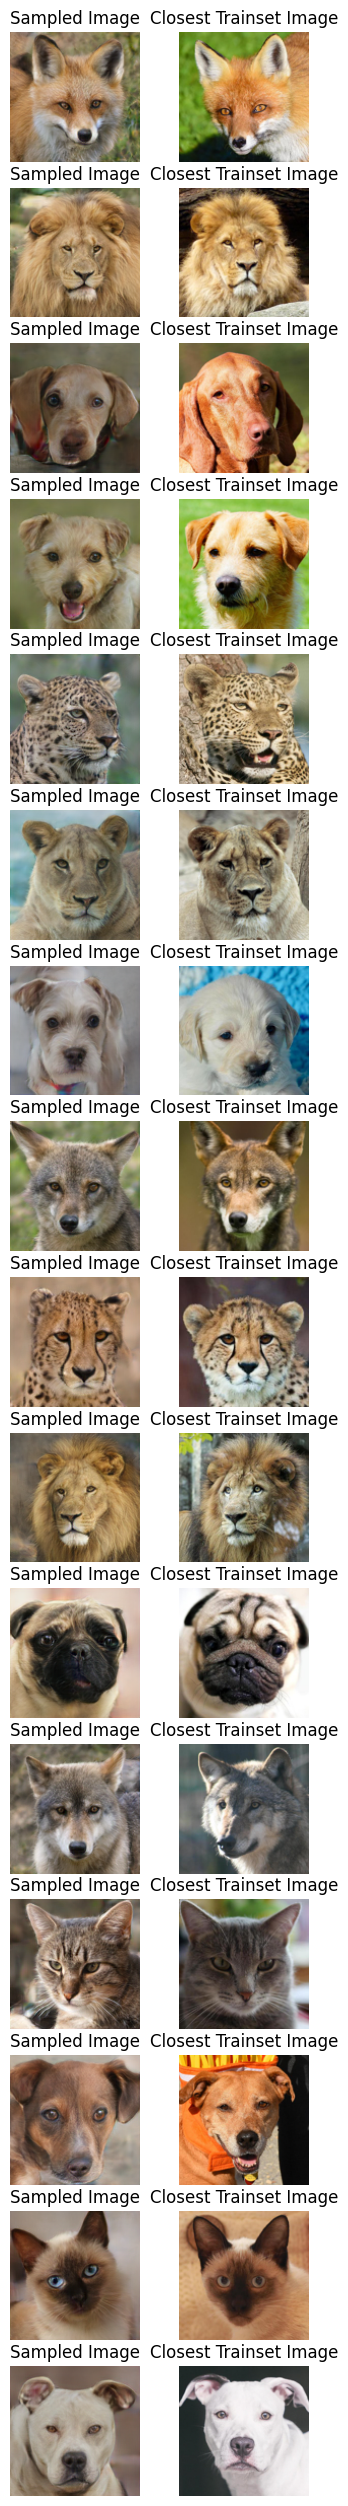

In [120]:
# plot the query and close images
fig, axes = plt.subplots(N, 2, figsize=(4, 2*N))
for i, (img_file, ids) in enumerate(zip(sampled_images, close_ids)):
    query_img = Image.open(img_file)
    query_img = query_img.resize((128, 128))
    axes[i, 0].imshow(query_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Sampled Image")

    for j, id in enumerate(ids):
        img = Image.open(train_files[id])
        img = img.resize((128, 128))
        axes[i, j+1].imshow(img)
        axes[i, j+1].axis('off')
        axes[i, j+1].set_title(f"Closest Trainset Image")

In [111]:
mae_sampled_image_dir = "logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119"
mae_sampled_img_files = os.listdir(mae_sampled_image_dir)
mae_sampled_img_files = [join(mae_sampled_image_dir, f) for f in mae_sampled_img_files]
mae_sampled_img_files[:10]

['logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_002136.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_000792.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_003996.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_002356.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_001994.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_001422.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_000178.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/img/epoch=000119/sample_001399.png',
 'logs/2024-04-27T19-42-30_afhq-ldm-kl-16-mae-vae/samples_2024-04-28-22-53-07/im

In [121]:
mae_sampled_imges = random.choices(mae_sampled_img_files, k=N)

close_ids = []
for img_file in mae_sampled_imges:
    # find the closest image in the training set
    query = extract(img_file, model)  # Extract features from the query image
    dists = np.linalg.norm(all_features - query, axis=1)  # Calculate the similarity (distance) between images
    ids = np.argsort(dists)[:1]  # Extract image that have lowest distance
    close_ids.append(ids)

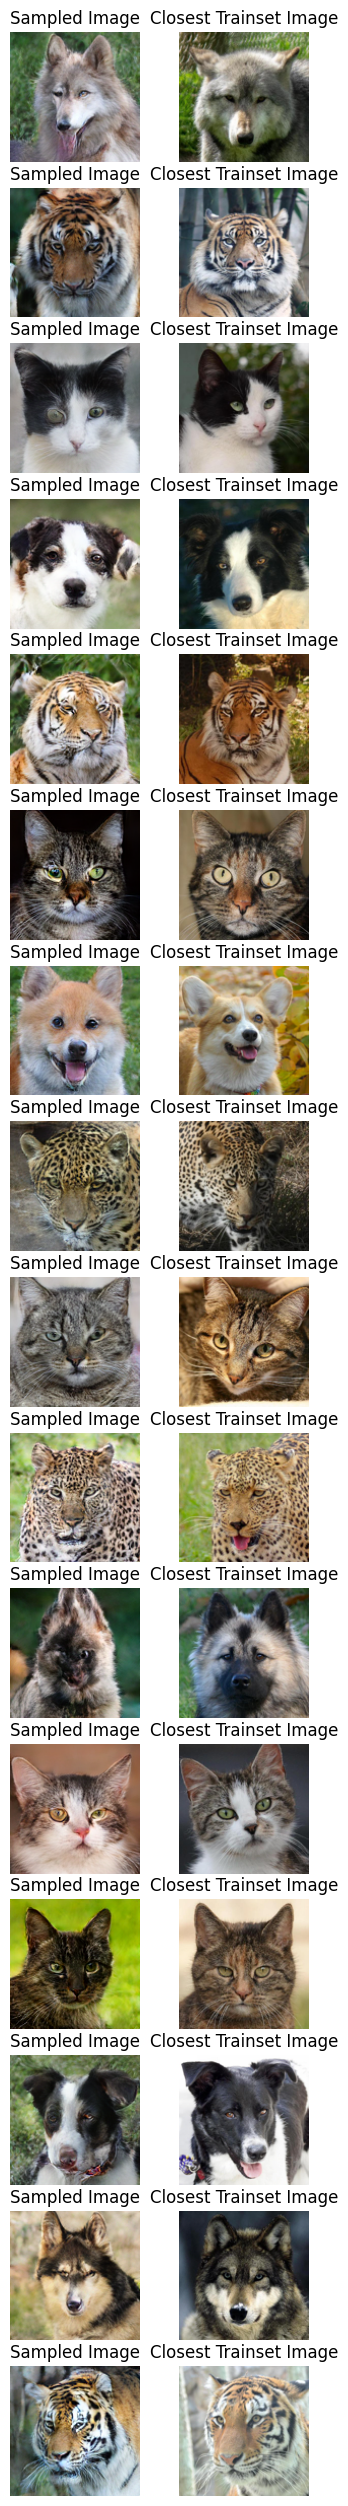

In [122]:
# plot the query and close images
fig, axes = plt.subplots(N, 2, figsize=(4, 2*N))
for i, (img_file, ids) in enumerate(zip(mae_sampled_imges, close_ids)):
    query_img = Image.open(img_file)
    query_img = query_img.resize((128, 128))
    axes[i, 0].imshow(query_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Sampled Image")

    for j, id in enumerate(ids):
        img = Image.open(train_files[id])
        img = img.resize((128, 128))
        axes[i, j+1].imshow(img)
        axes[i, j+1].axis('off')
        axes[i, j+1].set_title(f"Closest Trainset Image")